In [102]:
%pip install torch torchvision torchaudio

Note: you may need to restart the kernel to use updated packages.


In [115]:
# Very first thing is to clean our data. Let's make a csv file with only the relevant columns:
import pandas as pd
import numpy as np


# Edit the next line to pick what we are researching
research = 'loan'

file_path = f'data/{research}_data.csv'  

if research == "diabetic":
    df = pd.read_csv(file_path)
    # Only keep the columns we need
    selected_columns = [
        'race', 'gender', 'age',
        'admission_type_id', 'discharge_disposition_id', 'admission_source_id',
        'time_in_hospital', 'num_lab_procedures', 'num_procedures', 'num_medications',
        'number_outpatient', 'number_emergency', 'number_inpatient', 'number_diagnoses',
        'max_glu_serum', 'A1Cresult', 'diabetesMed'
    ]
    df = df[selected_columns]
    # Keep only rows where gender is "Male" or "Female"
    df = df[df['gender'].isin(['Male', 'Female'])]

    # Drop rows where race is missing (i.e., "?")
    df = df[df['race'] != '?']
    df['target'] = df['diabetesMed'].map({'Yes': 1, 'No': 0})

    

    # Drop rows where target is missing
    df = df[df['target'].notna()]

    # One-hot encode categorical features
    categorical_features = ['race', 'gender', 'age', 'admission_type_id', 'discharge_disposition_id', 'admission_source_id', 'max_glu_serum', 'A1Cresult']
    df = pd.get_dummies(df, columns=categorical_features)

    # Don't keep diabetesMed column
    df_with_target = df.copy()
    df = df.drop(columns=['diabetesMed'])

elif research == 'income':
    df = pd.read_csv(file_path)
    selected_columns = [
        'age', 'workclass', 'education', 'education-num', 'marital-status', 'occupation',
        'relationship', 'race', 'sex', 'capital-gain', 'capital-loss', 'hours-per-week', 'native-country', 'income'
    ]
    df = df[selected_columns]       
    # Keep only rows where gender is "Male" or "Female"
    df = df[df['sex'].isin(['Male', 'Female'])]

    # Drop rows where race is missing (i.e., "?")
    df = df[df['race'] != '?']
    df = df[df['workclass'] != '?']
    df = df[df['occupation'] != '?']
    df = df[df['native-country'] != '?']
    df['target'] = df['income'].map({'>50K': 1, '<=50K': 0})

    

    # Drop rows where target is missing
    df = df[df['target'].notna()]

    # One-hot encode categorical features
    categorical_features = ['workclass', 'education', 'marital-status', 'occupation', 'relationship', 'race', 'sex', 'native-country']
    df = pd.get_dummies(df, columns=categorical_features)
    
    # Don't keep income column
    df_with_target = df.copy()
    df = df.drop(columns=['income'])

elif research == 'loan':
    
    # Rename FIRST
    df = pd.read_csv(file_path, dtype=str, low_memory=False)
    df.rename(columns={'derived_race': 'race', 'derived_sex': 'sex'}, inplace=True)
    df['race'] = df['race'].replace({'Black or African American': 'Black'})
    # Use the renamed column names
    selected_columns = [
        'derived_dwelling_category', 'conforming_loan_limit', 'race', 'sex', 'action_taken', 'loan_type', 'loan_purpose',
        'lien_status', 'reverse_mortgage', 'open-end_line_of_credit', 'business_or_commercial_purpose', 'loan_amount', 'loan_to_value_ratio', 'hoepa_status', 'loan_term', 'negative_amortization', 'interest_only_payment', 'balloon_payment', 'other_nonamortizing_features',
        'property_value', 'occupancy_type', 'manufactured_home_secured_property_type', 'manufactured_home_land_property_interest',
        'income', 'debt_to_income_ratio', 'applicant_credit_score_type', 'applicant_race_observed', 'applicant_sex_observed', 'applicant_age', 
        'tract_population', 'tract_minority_population_percent', 'ffiec_msa_md_median_family_income', 'tract_to_msa_income_percentage'
    ]
    df = df[selected_columns]

    # Now use renamed 'race' safely
    categorical_features = ['derived_dwelling_category', 'conforming_loan_limit', 'race', 'sex', 'loan_type', 'loan_purpose', 'lien_status',
                            'reverse_mortgage', 'open-end_line_of_credit', 'business_or_commercial_purpose', 'hoepa_status', 'negative_amortization', 'interest_only_payment',
                            'balloon_payment', 'other_nonamortizing_features', 'occupancy_type', 'manufactured_home_secured_property_type', 'manufactured_home_land_property_interest',
                            'debt_to_income_ratio', 'applicant_credit_score_type', 'applicant_race_observed', 'applicant_sex_observed', 'applicant_age']

    # Drop rows with invalid categorical values
    invalid_vals = ['', 'nan', 'NaN', 'NA']
    df = df[~df[categorical_features].astype(str).isin(invalid_vals).any(axis=1)]

    # Create target
    df['target'] = df['action_taken'].map({'1': 1, '3': 0})

    # One-hot encode
    df = pd.get_dummies(df, columns=categorical_features)
    for col in df.columns:
        df[col] = pd.to_numeric(df[col], errors='coerce')  # invalid values → NaN
    # Finalize
    df = df.dropna()
    df_with_target = df.copy()
    df = df.drop(columns=['action_taken'])

print(len(df.columns))
col = "target"
unique_count = df[col].nunique()
    
print(f"\n{col}:")

print(f"Unique values: {unique_count}") 
print(df[col].value_counts())
print(len(df))
    

116

target:
Unique values: 2
target
1    280180
0     88862
Name: count, dtype: int64
369042


In [ ]:
# We want to divide our data into training, evaluation, and testing sets
from sklearn.model_selection import train_test_split

X = df.drop(columns='target')
y = df['target']
# First split: 80% for train+eval, 20% for test

X_train_eval, X_test, y_train_eval, y_test = train_test_split(X, y, stratify=y, test_size=0.2, random_state=42)
# Second split: 70% for train, 10% for eval (from the remaining 80%)
# We use 0.125 because 0.1/0.8 = 0.125 to get 10% of the total data
X_train, X_eval, y_train, y_eval = train_test_split(X_train_eval, y_train_eval, stratify=y_train_eval, test_size=0.125, random_state=42)
print(f"Training set size: {len(X_train)} ({len(X_train)/len(df)*100:.1f}%)")
print(f"Evaluation set size: {len(X_eval)} ({len(X_eval)/len(df)*100:.1f}%)")
print(f"Test set size: {len(X_test)} ({len(X_test)/len(df)*100:.1f}%)")

from sklearn.preprocessing import StandardScaler

# Scale all data fit to training data only.
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_scaled = scaler.transform(X)
X_eval_scaled = scaler.transform(X_eval)
X_test_scaled = scaler.transform(X_test)


Training set size: 258328 (70.0%)
Evaluation set size: 36905 (10.0%)
Test set size: 73809 (20.0%)


In [105]:
# Train a simple logistic regression model
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score, roc_auc_score, classification_report

logreg = LogisticRegression(max_iter=1000)
logreg.fit(X_train_scaled, y_train)

# Evaluate the model
y_pred = logreg.predict(X_eval_scaled)
y_prob = logreg.predict_proba(X_eval_scaled)[:, 1]

accuracy = accuracy_score(y_eval, y_pred)
auc = roc_auc_score(y_eval, y_prob)
report = classification_report(y_eval, y_pred, output_dict=True)

print(f"Accuracy: {accuracy:.6f}, \nAUC: {auc:.6f}, \nPrecision: {report['1']['precision']:.6f},\nRecall: {report['1']['recall']:.6f}, \nF1: {report['1']['f1-score']:.6f}")


Accuracy: 0.973906, 
AUC: 0.996313, 
Precision: 0.987355,
Recall: 0.978158, 
F1: 0.982735


In [116]:
# Mostly for testing, we want to make sure we are not including variables that only can take on certain values because of the dependent variable.
# Only can use features that come about before the outcome is decided.
# Get feature names
feature_names = X_train.columns if isinstance(X_train, pd.DataFrame) else [f"x{i}" for i in range(X_train.shape[1])]

# Get coefficients
coefs = logreg.coef_[0]  # shape: (n_features,)

# Create a DataFrame for easy viewing
importance_df = pd.DataFrame({
    'feature': feature_names,
    'coefficient': coefs,
    'abs_coef': np.abs(coefs)
})

# Sort by magnitude of coefficient
importance_df = importance_df.sort_values(by='abs_coef', ascending=False)

print(importance_df.head(50))  # Top 20 most influential features

                                               feature  coefficient  abs_coef
44                                      hoepa_status_3    -3.469871  3.469871
43                                      hoepa_status_2     3.449377  3.449377
88                           debt_to_income_ratio_>60%    -1.093951  1.093951
1                                  loan_to_value_ratio    -0.654478  0.654478
25                                      loan_purpose_1     0.452776  0.452776
57                                    occupancy_type_1    -0.432298  0.432298
86                        debt_to_income_ratio_50%-60%    -0.415087  0.415087
59                                    occupancy_type_3     0.330219  0.330219
26                                      loan_purpose_2    -0.296617  0.296617
58                                    occupancy_type_2     0.278070  0.278070
103                          applicant_race_observed_3    -0.256598  0.256598
42                                      hoepa_status_1     0.240

In [1]:
# Now we train a CNN instead, just to compare results
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import TensorDataset, DataLoader
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')


In [108]:
# Prepare the data
X_tensor = torch.tensor(X_scaled, dtype=torch.float32).unsqueeze(1)
y_tensor = torch.tensor(y.values, dtype=torch.float32).unsqueeze(1)

X_train_tensor = torch.tensor(X_train_scaled, dtype=torch.float32).unsqueeze(1)  # Add channel dim
y_train_tensor = torch.tensor(y_train.values, dtype=torch.float32).unsqueeze(1)

X_eval_tensor = torch.tensor(X_eval_scaled, dtype=torch.float32).unsqueeze(1)
y_eval_tensor = torch.tensor(y_eval.values, dtype=torch.float32).unsqueeze(1)

X_test_tensor = torch.tensor(X_test_scaled, dtype=torch.float32).unsqueeze(1)
y_test_tensor = torch.tensor(y_test.values, dtype=torch.float32).unsqueeze(1)

total_dataset = TensorDataset(X_tensor, y_tensor)
train_dataset = TensorDataset(X_train_tensor, y_train_tensor)
eval_dataset = TensorDataset(X_eval_tensor, y_eval_tensor)
test_dataset = TensorDataset(X_test_tensor, y_test_tensor)

total_loader = DataLoader(total_dataset, batch_size=64)
train_loader = DataLoader(train_dataset, batch_size=64, shuffle=True)
eval_loader = DataLoader(eval_dataset, batch_size=64)
test_loader = DataLoader(test_dataset, batch_size=64)

# CNN model
class TabularCNN(nn.Module):
    def __init__(self, input_len):
        super(TabularCNN, self).__init__()
        self.conv1 = nn.Conv1d(in_channels=1, out_channels=8, kernel_size=3)
        self.relu = nn.ReLU()
        self.flatten = nn.Flatten()
        self.fc1 = nn.Linear((input_len - 2) * 8, 32)  # Adjust shape after conv
        self.fc2 = nn.Linear(32, 1)
        self.sigmoid = nn.Sigmoid()

    def forward(self, x):
        x = self.conv1(x)
        x = self.relu(x)
        x = self.flatten(x)
        x = self.relu(self.fc1(x))
        x = self.sigmoid(self.fc2(x))
        return x

# Instantiate model
model = TabularCNN(input_len=X_train_scaled.shape[1])
criterion = nn.BCELoss()
optimizer = optim.Adam(model.parameters(), lr=0.00001)

In [109]:
def evaluate(verbose=False):
    model.eval()
    with torch.no_grad():
        y_pred_prob = model(X_eval_tensor).numpy()
        y_pred_label = (y_pred_prob > 0.5).astype(int)
    y_true = y_eval_tensor.numpy().astype(int)
    accuracy = accuracy_score(y_true, y_pred_label)
    if(verbose):
        auc = roc_auc_score(y_true, y_pred_prob)
        report = classification_report(y_true, y_pred_label, output_dict=True)
        print(f"Accuracy: {accuracy}, \nAUC: {auc}, \nPrecision: {report['1']['precision']},\nRecall: {report['1']['recall']}, \nF1: {report['1']['f1-score']}")
    return accuracy

#Same thing, just on the test set
def test(verbose=False):
    model.eval()
    with torch.no_grad():
        y_pred_prob = model(X_test_tensor).numpy()
        y_pred_label = (y_pred_prob > 0.5).astype(int)
    y_true = y_test_tensor.numpy().astype(int)
    accuracy = accuracy_score(y_true, y_pred_label)
    if(verbose):
        auc = roc_auc_score(y_true, y_pred_prob)
        report = classification_report(y_true, y_pred_label, output_dict=True)
        print(f"Accuracy: {accuracy}, \nAUC: {auc}, \nPrecision: {report['1']['precision']},\nRecall: {report['1']['recall']}, \nF1: {report['1']['f1-score']}")
    return accuracy

In [110]:
# Training loop
train = False
from pathlib import Path
model_save_filepath = f'models/baselineCNN_{research}'
if(train):
    max_eval_accuracy = 0
    max_epochs = 1000
    max_epochs_without_improvement = 50
    current_epochs_without_improvement = 0
    if Path(model_save_filepath).exists():
        model.load_state_dict(torch.load(model_save_filepath, weights_only=True))
        max_eval_accuracy = evaluate()
    for epoch in range(max_epochs):
        model.train()
        for inputs, labels in train_loader:
            outputs = model(inputs)
            loss = criterion(outputs, labels)
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()
        print(f"Epoch {epoch+1} loss: {loss.item():.4f}")
        # Evaluate
        model.eval()
        with torch.no_grad():
            predictions = model(X_eval_tensor)
            predicted_classes = (predictions > 0.5).float()
        accuracy = (predicted_classes == y_eval_tensor).float().mean().item()
        print(f"Evaluation Accuracy: {accuracy:.4f}")
        if(accuracy > max_eval_accuracy):
            torch.save(model.state_dict(), model_save_filepath)
            current_epochs_without_improvement = 0
            max_eval_accuracy = accuracy
            print("Saved model")
        else:
            current_epochs_without_improvement += 1
            if current_epochs_without_improvement > max_epochs_without_improvement:
                break
else:
    if Path(model_save_filepath).exists():
        model.load_state_dict(torch.load(model_save_filepath, weights_only=True))
        max_eval_accuracy = evaluate()


In [111]:
# Evaluate

model.load_state_dict(torch.load(model_save_filepath, weights_only=True))
evaluate(verbose=True)
test(verbose=True)


Accuracy: 0.9779162715079257, 
AUC: 0.9973973843686998, 
Precision: 0.9876317487631748,
Recall: 0.983225668296513, 
F1: 0.9854237833777476
Accuracy: 0.9779566177566421, 
AUC: 0.9972777550503389, 
Precision: 0.9876494523813791,
Recall: 0.9832607609393961, 
F1: 0.985450220437656


0.9779566177566421

In [112]:
# Now we experiment
# This can mostly be done for the final project step, but let's do a similar analysis to HW1, seeing the bias in the data itself.
from matplotlib import pyplot as plt


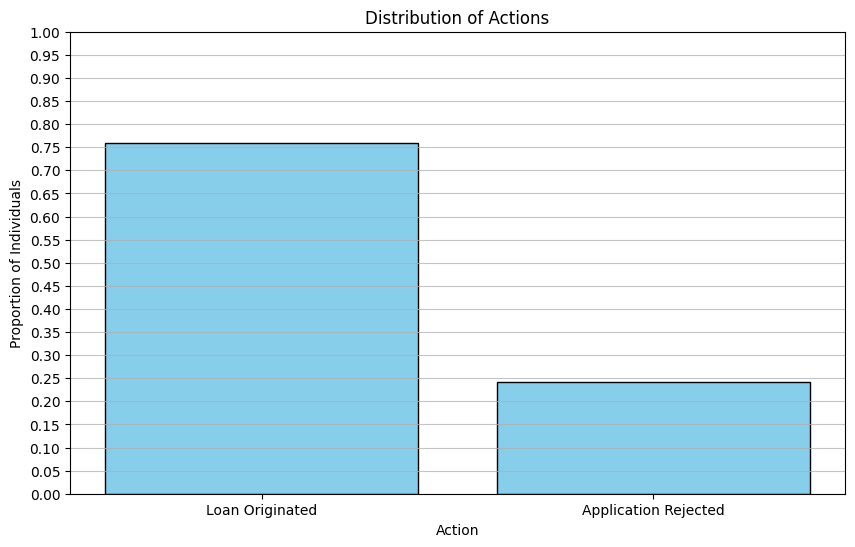

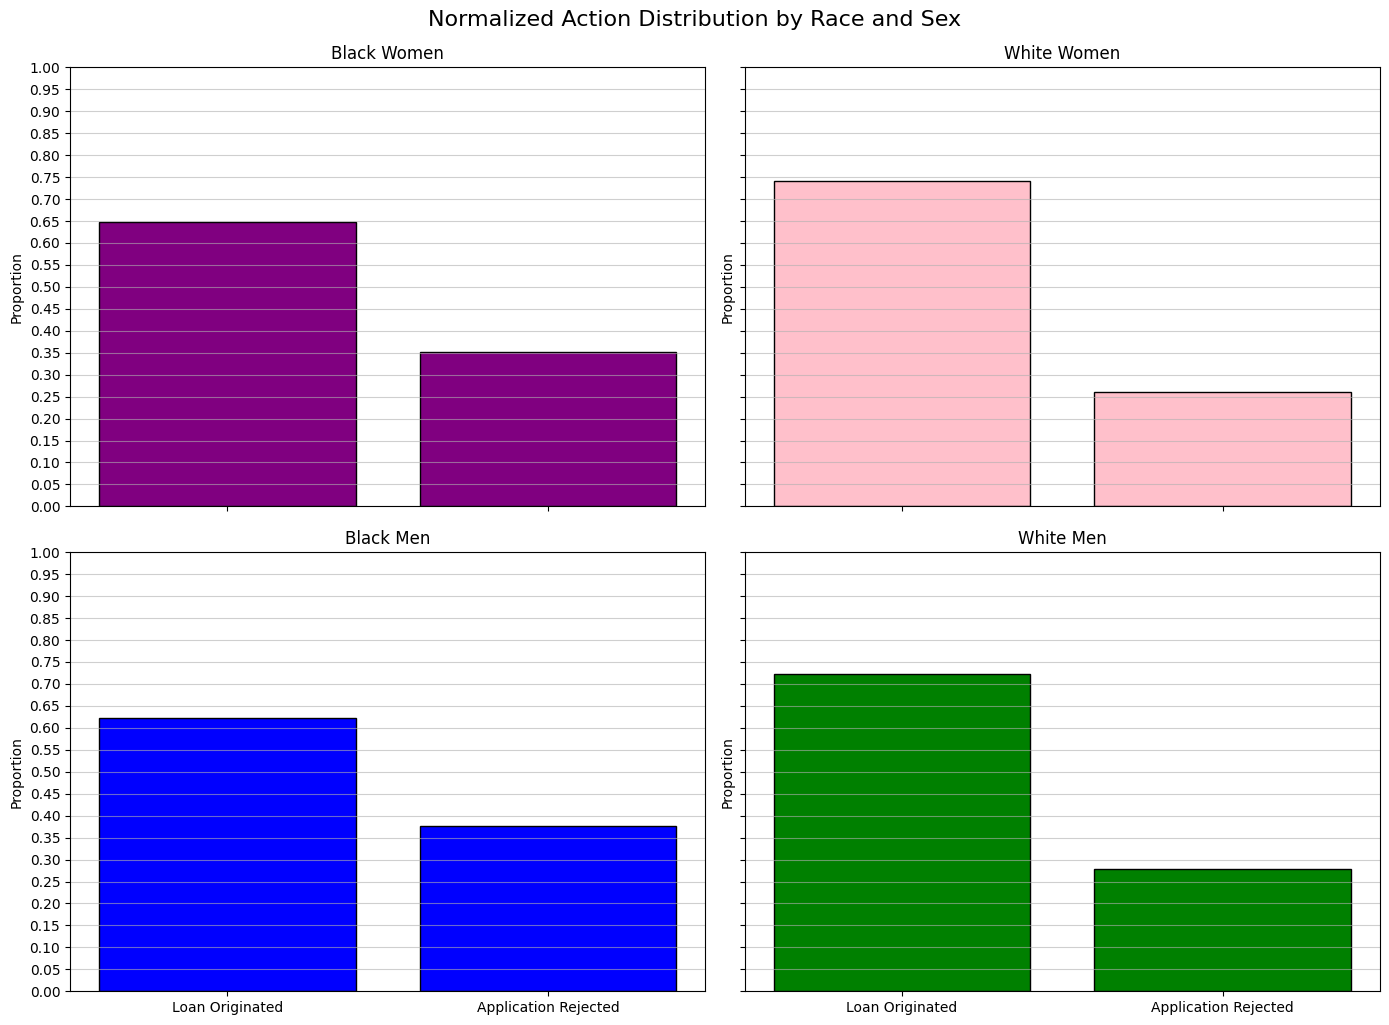

In [113]:
if research == 'income':
    plt.figure(figsize=(10, 6))
    income_counts = df_with_target['income'].value_counts(normalize=True).sort_index()
    labels = ['<=50K', '>50K']  # Adjust if needed
    plt.bar(labels, income_counts, color='skyblue', edgecolor='black')
    plt.title('Distribution of Income')
    plt.xlabel('Income')
    plt.ylabel('Proportion of Individuals')
    plt.grid(axis='y', alpha=0.75)
    plt.show()

    # b. Plot the distribution of scores for (four separate histograms): 
    # Black women, white women, Black men, white men
    black_women = df_with_target[(df_with_target['race_Black'] == 1) & (df_with_target['sex_Female'] == 1)]
    white_women = df_with_target[(df_with_target['race_White'] == 1) & (df_with_target['sex_Female'] == 1)]
    black_men = df_with_target[(df_with_target['race_Black'] == 1) & (df_with_target['sex_Male'] == 1)]
    white_men = df_with_target[(df_with_target['race_White'] == 1) & (df_with_target['sex_Male'] == 1)]

    fig, axes = plt.subplots(2, 2, figsize=(14, 10), sharex=True, sharey=True)


    # Helper function to plot normalized histograms
    def plot_normalized_hist(ax, data, title, color):
        counts = data['income'].value_counts(normalize=True).sort_index()
        ax.bar(labels, counts, color=color, edgecolor='black')
        ax.set_title(title)
        ax.set_ylim(0, 1)  # percentage scale

    plot_normalized_hist(axes[0, 0], black_women, 'Black Women', 'purple')
    plot_normalized_hist(axes[0, 1], white_women, 'White Women', 'pink')
    plot_normalized_hist(axes[1, 0], black_men, 'Black Men', 'blue')
    plot_normalized_hist(axes[1, 1], white_men, 'White Men', 'green')

    for ax in axes.flat:
        ax.set_ylabel('Proportion')
        ax.grid(axis='y', alpha=0.6)

    plt.tight_layout()
    plt.suptitle('Normalized Income Distribution by Race and Sex', fontsize=16, y=1.02)
    plt.show()

elif research == 'loan':
    plt.figure(figsize=(10, 6))
    action_counts = df_with_target['action_taken'].value_counts(normalize=True).sort_index()
    labels = ['Loan Originated', 'Application Rejected']  # Adjust if needed
    plt.bar(labels, action_counts, color='skyblue', edgecolor='black')
    plt.title('Distribution of Actions')
    plt.xlabel('Action')
    plt.ylabel('Proportion of Individuals')
    plt.yticks(np.arange(0, 1.05, 0.05))

    plt.grid(axis='y', alpha=0.75)
    
    plt.show()

    # b. Plot the distribution of scores for (four separate histograms): 
    # Black women, white women, Black men, white men
    black_women = df_with_target[(df_with_target['race_Black'] == 1) & (df_with_target['sex_Female'] == 1)]
    white_women = df_with_target[(df_with_target['race_White'] == 1) & (df_with_target['sex_Female'] == 1)]
    black_men = df_with_target[(df_with_target['race_Black'] == 1) & (df_with_target['sex_Male'] == 1)]
    white_men = df_with_target[(df_with_target['race_White'] == 1) & (df_with_target['sex_Male'] == 1)]

    fig, axes = plt.subplots(2, 2, figsize=(14, 10), sharex=True, sharey=True)


    # Helper function to plot normalized histograms
    def plot_normalized_hist(ax, data, title, color):
        counts = data['action_taken'].value_counts(normalize=True).sort_index()
        ax.bar(labels, counts, color=color, edgecolor='black')
        ax.set_title(title)
        ax.set_ylim(0, 1)  # percentage scale

    plot_normalized_hist(axes[0, 0], black_women, 'Black Women', 'purple')
    plot_normalized_hist(axes[0, 1], white_women, 'White Women', 'pink')
    plot_normalized_hist(axes[1, 0], black_men, 'Black Men', 'blue')
    plot_normalized_hist(axes[1, 1], white_men, 'White Men', 'green')

    for ax in axes.flat:
        ax.set_ylabel('Proportion')
        ax.grid(axis='y', alpha=0.6)
        ax.set_yticks(np.arange(0, 1.05, 0.05))

    plt.tight_layout()
    plt.suptitle('Normalized Action Distribution by Race and Sex', fontsize=16, y=1.02)
    
    plt.show()

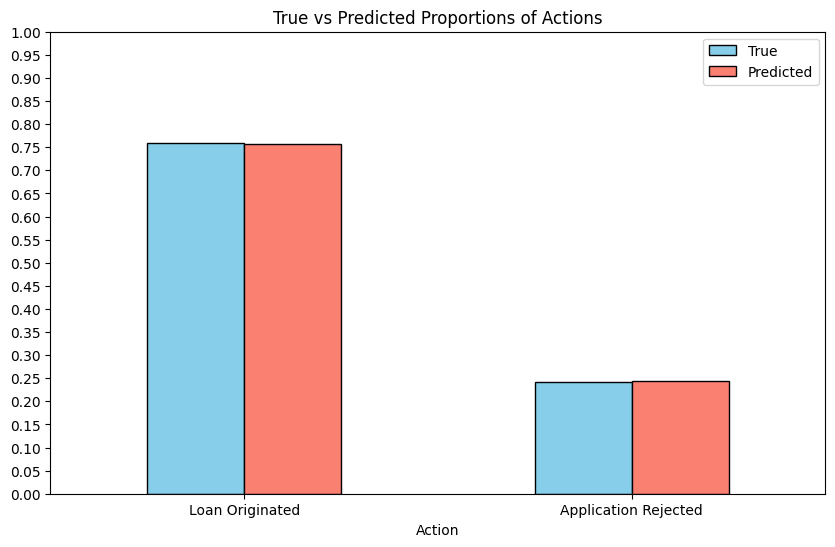

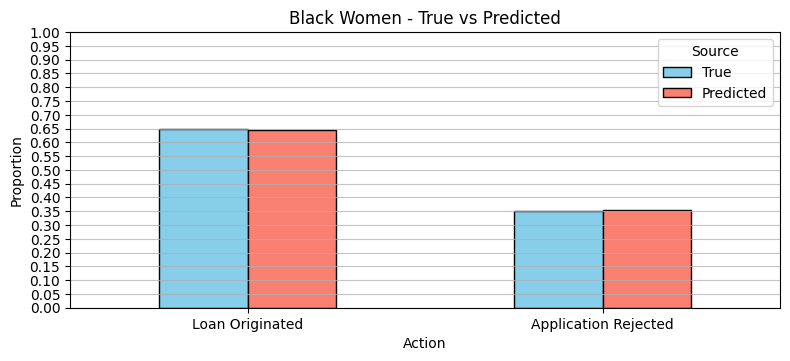

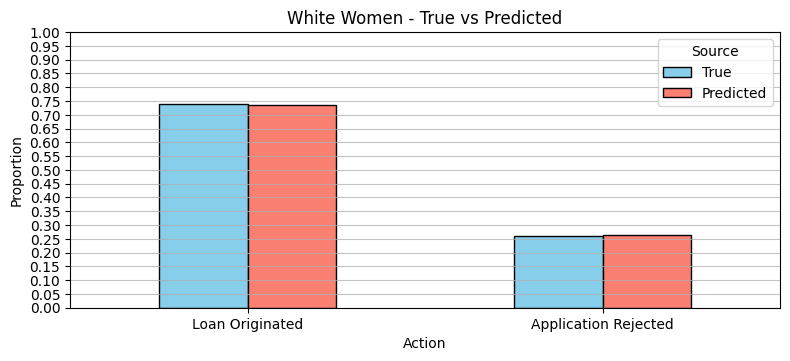

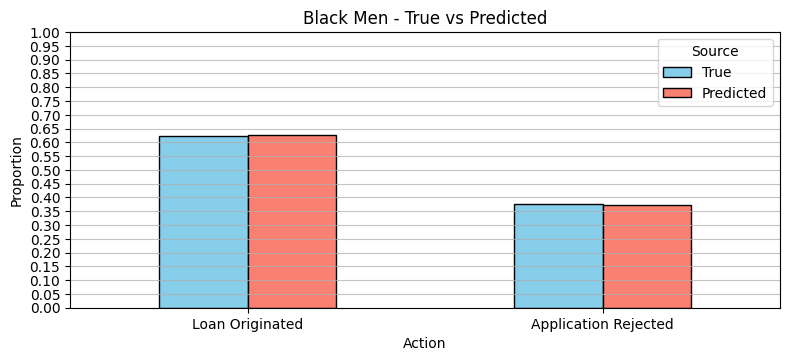

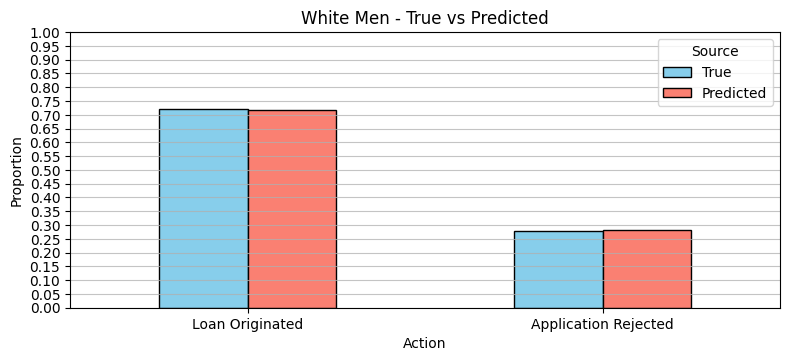

In [114]:
model.eval()
with torch.no_grad():
    y_pred_prob = model(X_tensor).numpy()
    y_pred_label = (y_pred_prob > 0.5).astype(int)
# Flatten predicted labels
y_pred_label_flat = y_pred_label.ravel()
if research == 'income':
    label_map = {1: '<=50K', 0: '>50K'}
elif research == 'loan':
    label_map = {1: 'Loan Originated', 0: 'Application Rejected'}  # adjust if needed
true_labels = df_with_target['target'].map(label_map)
pred_labels = pd.Series(y_pred_label_flat).map(label_map)

# Value counts (normalized)
true_counts = true_labels.value_counts(normalize=True)
pred_counts = pred_labels.value_counts(normalize=True)

# Combine into a DataFrame
df_plot = pd.DataFrame({
    'True': true_counts,
    'Predicted': pred_counts
}).fillna(0)  # Fill missing values if a class isn't predicted
# Plot

df_plot.plot(kind='bar', figsize=(10, 6), color=['skyblue', 'salmon'], edgecolor='black')
plt.yticks(np.arange(0, 1.05, 0.05))
plt.xticks(rotation=0)
black_women = df_with_target[(df_with_target['race_Black'] == 1) & (df_with_target['sex_Female'] == 1)]
white_women = df_with_target[(df_with_target['race_White'] == 1) & (df_with_target['sex_Female'] == 1)]
black_men = df_with_target[(df_with_target['race_Black'] == 1) & (df_with_target['sex_Male'] == 1)]
white_men = df_with_target[(df_with_target['race_White'] == 1) & (df_with_target['sex_Male'] == 1)]

X_bw_scaled = scaler.transform(black_women.drop(columns=['action_taken', 'target']))
X_ww_scaled = scaler.transform(white_women.drop(columns=['action_taken', 'target']))
X_bm_scaled = scaler.transform(black_men.drop(columns=['action_taken', 'target']))
X_wm_scaled = scaler.transform(white_men.drop(columns=['action_taken', 'target']))
X_bw_tensor = torch.tensor(X_bw_scaled, dtype=torch.float32).unsqueeze(1)
X_ww_tensor = torch.tensor(X_ww_scaled, dtype=torch.float32).unsqueeze(1)
X_bm_tensor = torch.tensor(X_bm_scaled, dtype=torch.float32).unsqueeze(1)
X_wm_tensor = torch.tensor(X_wm_scaled, dtype=torch.float32).unsqueeze(1)
groups = {
    "Black Women": (black_women, X_bw_tensor),
    "White Women": (white_women, X_ww_tensor),
    "Black Men": (black_men, X_bm_tensor),
    "White Men": (white_men, X_wm_tensor)
}

if research == 'income':
    plt.title('True vs Predicted Proportions of Actions')
    plt.xlabel('Action')

elif research == 'loan':
    plt.title('True vs Predicted Proportions of Actions')
    plt.xlabel('Action')

for group_name, (group_df, group_X_tensor) in groups.items():
    with torch.no_grad():
        y_pred_prob = model(group_X_tensor).numpy()
        y_pred_label = (y_pred_prob > 0.5).astype(int).ravel()

    # Map labels to strings
    true_labels = group_df['target'].map(label_map)
    pred_labels = pd.Series(y_pred_label).map(label_map)

    # Value counts (normalized)
    true_counts = true_labels.value_counts(normalize=True)
    pred_counts = pred_labels.value_counts(normalize=True)

    # Combine into DataFrame
    df_plot = pd.DataFrame({
        'True': true_counts,
        'Predicted': pred_counts
    }).fillna(0)

    # Plot
    ax = df_plot.plot(kind='bar', figsize=(8, 5), color=['skyblue', 'salmon'], edgecolor='black')
    plt.title(f'{group_name} - True vs Predicted')
    plt.ylabel('Proportion')
    if research == 'income':
        plt.xlabel('Action')

    elif research == 'loan':
        plt.xlabel('Action')
    plt.ylim(0, 1)
    plt.yticks(np.arange(0, 1.05, 0.05))
    plt.grid(axis='y', alpha=0.75)
    plt.legend(title='Source')
    plt.tight_layout()
    plt.ylabel('Proportion')
    plt.xticks(rotation=0)
    plt.show()
